In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import numpy as np
import pdb

# my code
from distribution import PolynomialSigmoidBernoulli, GaussianNoise
from gaussian_mixture_analytic_expectations import *
from fully_observed_models import MixtureOfTwoGaussians, SumOfTwoUnnormalisedGaussians2
from latent_variable_model import LatentMixtureOfTwoUnnormalisedGaussians2
from nce_optimiser import NCEOptimiser
from mle_optimiser import MLEOptimiser
from utils import evaluate_loss_at_param
from vnce_optimiser import VemOptimiser, ScipyMinimiseEmStep, ExactEStep, VnceLossWithAnalyticExpectations

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [3]:
# For reproducibility
rng = rnd.RandomState(1083463236)
save_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/experiments/mog/unnormalised_variationalem'
os.makedirs(save_dir, exist_ok=True)

In [4]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
sigma1 = 1
sigma0 = 4  # (parameter of interest)

n = 10000 # number of data points
nz = 1  # number of latent samples per datapoint
nu = 1 # nu is the ratio of noise to data samples in NCE
c0 = np.log(2) + 0.5*np.log(2*np.pi) + np.log(sigma0)   # true value of 1st scaling parameter
c1 = np.log(2) + 0.5*np.log(2*np.pi) + np.log(sigma1)   # true value of 2nd scaling parameter

true_theta = np.array([c0, c1, np.log(sigma0)])
true_alpha = np.array([c1 - c0, 0, (1 / (2*sigma1**2)) - (1 / (2*sigma0**2))])

theta0 = np.array([0, 0.1, 1])  # initial theta
# theta0 = true_theta
alpha0 = np.array([0, -0.1, 0.1]) # initial alpha

In [5]:
# true dist is 0.5*N(u; 0, sigma0) + 0.5*N(u; 0, sigma1)
true_data_dist = MixtureOfTwoGaussians(theta=np.log(sigma0), sigma1=sigma1, rng=rng)
X = true_data_dist.sample(n) # generate data

In [6]:
noise = GaussianNoise(mean=0, cov=sigma0**2)
Y = noise.sample(int(n*nu))

In [7]:
model = LatentMixtureOfTwoUnnormalisedGaussians2(theta0, sigma1=sigma1)
nce_model = SumOfTwoUnnormalisedGaussians2(theta0, sigma1=sigma1)  # for comparison
# mle_model = SumOfTwoNormalisedGaussians(np.array([0]), sigma1 = sigma1)  # for comparison

In [8]:
var_dist = PolynomialSigmoidBernoulli(alpha=alpha0)

In [9]:
# E(r(x, z))
E1 = E_r
# E(log(psi_1(x, z)))
E2 = E_log_psi_1
# E((psi_1(x, z) - 1) / psi_1(x, z))
E3 = E_psi_1_ratio_times_grad_log_theta
# E(grad_theta(log(phi(u,z)) r(u, z))
E4 = E_r_times_grad_log_theta
# gradient_alpha(E(log(psi_1(x, z)))
E5 = grad_wrt_alpha_of_E_log_psi_1

In [10]:
nce_optimiser = NCEOptimiser(model=nce_model, noise=noise, noise_samples=Y, nu=nu, eps=10**-20)
# mle_optimiser = MLEOptimiser(model=mle_model)

In [11]:
loss_function = VnceLossWithAnalyticExpectations(model=model, 
                                                 noise=noise,
                                                 variational_q=var_dist,
                                                 E1=E1, 
                                                 E2=E2, 
                                                 E3=E3, 
                                                 E4=E4, 
                                                 E5=E5,
                                                 noise_to_data_ratio=nu)
m_step = ScipyMinimiseEmStep(do_m_step=True, optimisation_method='BFGS')  # Nelder-Mead
e_step = ScipyMinimiseEmStep(do_m_step=False, optimisation_method='BFGS')
optimiser = VemOptimiser(loss_function=loss_function, m_step=m_step, e_step=e_step)

In [12]:
optimiser.fit(X, Y, theta0=theta0, alpha0=alpha0, stop_threshold=1e-5)

         Current function value: 1.422530
         Iterations: 12
         Function evaluations: 89
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: 1.293450
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 1.291317
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.290901
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 1.290568
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 1.290301
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
Optimization

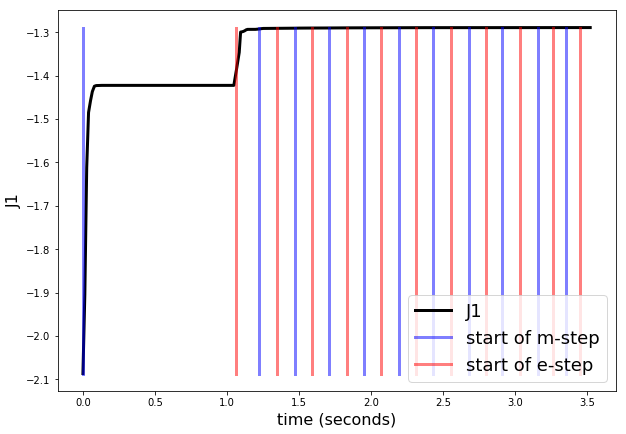

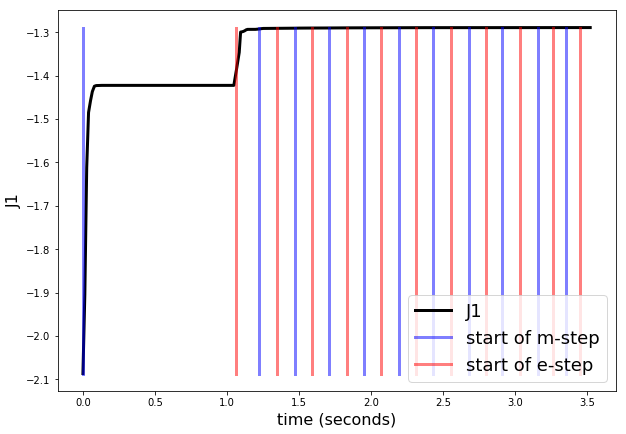

In [13]:
optimiser.plot_loss_curve()

In [14]:
nce_optimiser.fit(X, theta0=theta0, opt_method='L-BFGS-B')

(array([[0.17775223, 0.13568765, 0.72326086],
        [0.34002945, 0.1896845 , 0.70009551],
        [1.68720567, 0.66747741, 0.78001442],
        [2.89003006, 1.17579498, 1.0115306 ],
        [3.04084366, 1.3230761 , 1.15395267],
        [2.99521387, 1.43065269, 1.31057074],
        [3.03078538, 1.50534118, 1.37432482],
        [3.04716022, 1.54735062, 1.39843101],
        [3.03977655, 1.56728741, 1.40069569],
        [3.00817587, 1.61251256, 1.39268159],
        [2.97400721, 1.64221386, 1.37328942],
        [2.96266583, 1.6424979 , 1.36926739],
        [2.96461606, 1.64223674, 1.36877103],
        [2.96476686, 1.64164541, 1.36944929],
        [2.9647067 , 1.64162175, 1.36941823]]),
 array([-2.01078364, -1.94980511, -1.57985705, -1.3893102 , -1.33013141,
        -1.29421899, -1.29034686, -1.28984464, -1.28971629, -1.28947707,
        -1.28935141, -1.28934601, -1.28934592, -1.2893457 , -1.2893457 ]),
 array([0.        , 0.01384377, 0.02728319, 0.03970242, 0.05250144,
        0.06751156,

In [15]:
print('vnce parameter estimates are: \n'
      'scaling parameter 1: {} \n'
      'scaling parameter 2: {} \n'
      'standard deviation: {}'.format(optimiser.thetas[-1][-1][0], 
                                      optimiser.thetas[-1][-1][1],
                                      optimiser.thetas[-1][-1][2]))

vnce parameter estimates are: 
scaling parameter 1: 2.95048183568437 
scaling parameter 2: 1.656016618575523 
standard deviation: 1.365128803685785


In [16]:
print('nce parameter estimates are: \n'
      'scaling parameter 1: {} \n'
      'scaling parameter 2: {} \n'
      'standard deviation: {}'.format(nce_model.theta[0], 
                                      nce_model.theta[1], 
                                      nce_model.theta[2]))

nce parameter estimates are: 
scaling parameter 1: 2.964706702182818 
scaling parameter 2: 1.6416217534528552 
standard deviation: 1.3694182294646604


In [17]:
print('True parameters are: \n'
      'scaling parameter 1: {} \n'
      'scaling parameter 2: {} \n'
      'standard deviation: {}'.format(true_theta[0], true_theta[1], true_theta[2]))

True parameters are: 
scaling parameter 1: 2.9983800748845084 
scaling parameter 2: 1.612085713764618 
standard deviation: 1.3862943611198906
